# Example for context-specific TRN: perturbation of STARR-seq
Inference of transcriptional regulatory networks (TRNs) at specific loci is a complex and dynamic process. In this tutorial, we will guide you through context-specific TRN analysis using ChromBERTs, using the example of modelling perturbation effect of STARR-seq.  

**Attention: You should go through this [ tutorial ](https://chrombert.readthedocs.io/en/latest/tutorial_finetuning_ChromBERT.html) at first to get familiar with the basic usage of ChromBERT.**

In [1]:
import  os 
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # to selected gpu used 
os.environ["PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION"] = "python"
import sys 
import torch 
import numpy as np 
import pandas as pd 
from tqdm import tqdm 
from matplotlib import pyplot as plt
import chrombert
from torchinfo import summary

import scipy 
import h5py 
from sklearn.metrics.pairwise import cosine_similarity
import lightning.pytorch as pl
basedir =  os.path.expanduser("~/.cache/chrombert/data")



/home/yangdongxu/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## Fine-tune

### Dataset  

The first step is to prepare the dataset. The dataset used for the perturbation task is similar to those used in other tasks, with the exception of the `perturbation_object` column, which specifies the perturbation target for each sample.  

The `perturbation_object` can contain a list of data accessions joined by `;` or transcription regulator names joined by `;`. If no perturbation is applied to a sample, set it as `None` or the string `"none"`.  

This parameter can be defined for each sample individually or applied universally to all samples in the dataset. For the latter, it should be set in the configuration file.  

**Note:** Settings in the configuration will overwrite individual sample settings.

In [2]:
# below is a example setting `perturbation_object` for each sample
supervised_train = os.path.join(basedir, "demo", "starr", "train.csv")
df_train = pd.read_csv(supervised_train)
df_train

,chrom,start,end,build_region_index,label,perturbation_object
0,chr1,199241128,199242128,141732,1.956989,NaN
1,chr1,107707622,107708622,87175,2.505805,NaN
2,chr10,127935569,127936569,281197,2.637493,NaN
3,chr2,72258130,72259130,975449,1.491235,NaN
4,chr8,33612518,33613518,1889869,1.761900,NaN
...,...,...,...,...,...,...
34813,chr4,1388788,1389788,1355108,3.686819,GSM1121096;GSM1296385;GSM1313922
34814,chrX,3651041,3652041,2061995,0.914363,GSM602291;GSM449527;GSM525270;GSM525268;GSM393...
34815,chr5,135488689,135489689,1580262,1.735307,GSM971946;GSM1247824;GSM1328971;GSM1665999;GSM...
34816,chr10,87317757,87318757,247977,1.701492,GSM971946;GSM1247824;GSM1328971;GSM1665999;GSM...


In [3]:
dc = chrombert.get_preset_dataset_config(
    "general", supervised_file = supervised_train, 
    perturbation = True, 
    perturbation_value = 0  # Perturbation value controls the signal level:
                           # 0: Complete signal removal (similar to knock-out)
                           # 1-3: Intermediate signal reduction
                           # 4: Signal amplification (similar to over-expression)
    # Optional: Override perturbation targets by setting perturbation_object
    # Example: perturbation_object = "EP300;CREBBP" will perturb EP300 and CREBBP signals
    )
print(dc)

update path: hdf5_file = hg38_6k_1kb.hdf5
update path: meta_file = config/hg38_6k_meta.json
{
    "hdf5_file": "/home/yangdongxu/.cache/chrombert/data/hg38_6k_1kb.hdf5",
    "supervised_file": "/home/yangdongxu/.cache/chrombert/data/demo/starr/train.csv",
    "kind": "GeneralDataset",
    "meta_file": "/home/yangdongxu/.cache/chrombert/data/config/hg38_6k_meta.json",
    "ignore": false,
    "ignore_object": null,
    "batch_size": 8,
    "num_workers": 20,
    "shuffle": false,
    "pin_memory": true,
    "perturbation": true,
    "perturbation_object": null,
    "perturbation_value": 0,
    "prompt_kind": null,
    "prompt_regulator": null,
    "prompt_regulator_cache_file": null,
    "prompt_celltype": null,
    "prompt_celltype_cache_file": null,
    "prompt_regulator_cache_pin_memory": false,
    "prompt_regulator_cache_limit": 3,
    "fasta_file": null,
    "flank_window": 0
}


In [4]:
ds = dc.init_dataset()
# Example of perturbed dataset entry
# input_ids contains tokenized sequence where values 5-9 represent signal levels:
# 5: No signal (complete perturbation)
# 6-8: Intermediate signal levels 
# 9: Maximum signal level
ds[1] 

use perturbation_object in supervised_file


{'input_ids': tensor([5, 6, 5,  ..., 6, 6, 5], dtype=torch.int8),
 'position_ids': tensor([   1,    2,    3,  ..., 6389, 6390, 6391]),
 'region': tensor([        1, 107165000, 107166000], dtype=torch.int32),
 'build_region_index': 87175,
 'label': 2.505804511612648}

The dataset can be used in combination with the `ignore` functionality. In this case, we omit all other regulators and focus solely on transcription factors.

In [5]:
trs_all = pd.read_csv("~/.cache/chrombert/data/config/hg38_6k_regulators_list.txt", sep="\t", header=None)
tfs_all = pd.read_csv("~/.cache/chrombert/data/config/hg38_6k_factors_list.txt", sep="\t", header=None)
trs_nontf = ";".join(np.setdiff1d(trs_all, tfs_all))
trs_nontf

'5hmC;ATAC-seq;DNase;FAIRE;H1.0;H1.4;H2A;H2A.Bbd;H2A.Z;H2A.Zac;H2AFX;H2AFY;H2AK119ub;H2AK5ac;H2AX;H2AZ;H2AZK4ac, H2AZK7ac, H2AZK11ac;H2AZac;H2BK120ac;H2BK120ub;H2BK12ac;H2BK15ac;H2BK20ac;H2BK5ac;H2Bub;H3;H3-T45ph;H3.3;H3.3,H2A.Z;H3F3A;H3F3B;H3K122ac;H3K14ac;H3K18ac;H3K18cr;H3K23ac;H3K23me2;H3K27ac;H3K27me1;H3K27me3;H3K27me3/H3K4me3;H3K36ac;H3K36me1;H3K36me2;H3K36me3;H3K4ac;H3K4me1;H3K4me2;H3K4me3;H3K56ac;H3K79me1;H3K79me2;H3K79me3;H3K9/14ac;H3K9K14ac;H3K9ac;H3K9me1;H3K9me2;H3K9me3;H3Kac;H3R26Cit;H3T11ph;H3T6ph;H3Y;H3ac;H4;H4K12ac;H4K16ac;H4K20me1;H4K20me3;H4K5ac;H4K5ac, H4K8ac, H4K12ac, H4K16ac;H4K8ac;H4K91ac;H4TetraAc;H4ac;Histone Lysine Acetylation;Histone Lysine Crotonylation;Input;Rloop;macroH2A1;macroH2A2'

In [6]:
ignores=trs_nontf

dc = chrombert.get_preset_dataset_config(
    "general", supervised_file = supervised_train, 
    perturbation = True, 
    perturbation_value = 0, # choose from [0,1,2,3,4]
    # Optional: Override perturbation targets by setting perturbation_object
    # Example: perturbation_object = "EP300;CREBBP" will perturb EP300 and CREBBP signals
    ignore = True, 
    ignore_object = ignores,
    batch_size = 1
    )
ds = dc.init_dataset()
ignore_index = ds[1]["ignore_index"]
ds[1]

update path: hdf5_file = hg38_6k_1kb.hdf5
update path: meta_file = config/hg38_6k_meta.json


use perturbation_object in supervised_file


{'input_ids': tensor([6, 6, 6,  ..., 5, 6, 5], dtype=torch.int8),
 'position_ids': tensor([ 953,  959, 1147,  ..., 6388, 6389, 6391]),
 'region': tensor([        1, 107165000, 107166000], dtype=torch.int32),
 'build_region_index': 87175,
 'ignore_index': (array([2634, 2370, 1105, ..., 1994, 2237,  383]),
  array([  0,  27, 146, 213, 276, 277, 278, 279, 280, 281, 282, 283, 284,
         285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297,
         298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310,
         311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323,
         324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336,
         337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 369, 370,
         406, 474, 475, 672])),
 'label': 2.505804511612648}

### Load model

Loading the model follows the same procedure as for other tasks.

In [7]:
mc = chrombert.get_preset_model_config(
    "general", 
    ignore = True, 
    ignore_index = ignore_index,
    dropout = 0.1 # to fine-tune the model
)
print(mc)

update path: mtx_mask = config/hg38_6k_mask_matrix.tsv
update path: pretrain_ckpt = checkpoint/hg38_6k_1kb_pretrain.ckpt
{
    "genome": "hg38",
    "task": "general",
    "dim_output": 1,
    "mtx_mask": "/home/yangdongxu/.cache/chrombert/data/config/hg38_6k_mask_matrix.tsv",
    "dropout": 0.1,
    "pretrain_ckpt": "/home/yangdongxu/.cache/chrombert/data/checkpoint/hg38_6k_1kb_pretrain.ckpt",
    "finetune_ckpt": null,
    "ignore": true,
    "ignore_index": [
        [
            2634,
            2370,
            1105,
            358,
            1573,
            75,
            123,
            2870,
            2103,
            3874,
            745,
            1254,
            578,
            1560,
            1419,
            2517,
            1881,
            2330,
            1244,
            1692,
            2725,
            2833,
            842,
            2124,
            1260,
            2873,
            718,
            5,
            1770,
            

In [8]:
model = mc.init_model().cuda().bfloat16()
model.freeze_pretrain(trainable=2)
summary(model)

use organisim hg38; max sequence length is 6391


Ignoring 3057 cistromes and 82 regulators


Layer (type:depth-idx)                                  Param #
ChromBERTGeneral                                        --
├─ChromBERT: 1-1                                        --
│    └─BERTEmbedding: 2-1                               --
│    │    └─TokenEmbedding: 3-1                         (7,680)
│    │    └─PositionalEmbedding: 3-2                    (4,909,056)
│    │    └─Dropout: 3-3                                --
│    └─ModuleList: 2-2                                  --
│    │    └─EncoderTransformerBlock: 3-4                (6,497,280)
│    │    └─EncoderTransformerBlock: 3-5                (6,497,280)
│    │    └─EncoderTransformerBlock: 3-6                (6,497,280)
│    │    └─EncoderTransformerBlock: 3-7                (6,497,280)
│    │    └─EncoderTransformerBlock: 3-8                (6,497,280)
│    │    └─EncoderTransformerBlock: 3-9                (6,497,280)
│    │    └─EncoderTransformerBlock: 3-10               6,497,280
│    │    └─EncoderTransformerBlock

### Fine-Tune  

We provide a simple fine-tuning demonstration here. For practical applications, please refer to [ Compiled Scripts](https://chrombert.readthedocs.io/en/latest/finetune.html).


In [9]:
data_module = chrombert.LitChromBERTFTDataModule(
    config = dc.clone(batch_size=8),
    train_params = dict(supervised_file = os.path.join(basedir, "demo", "starr", "train.csv")),
    val_params = dict(supervised_file = os.path.join(basedir, "demo", "starr", "valid.csv")),
    test_params = dict(supervised_file = os.path.join(basedir, "demo", "starr", "test.csv")),
)
data_module

In [10]:
# Configure training parameters for demonstration purposes
# Note: These parameters are intentionally set for quick tutorial execution and are not optimal for production use
# For recommended hyperparameters, please refer to our manuscript
# Training time: ~30 minutes on NVIDIA A100 GPU

tc = chrombert.finetune.train.TrainConfig(
    kind = "regression",
    loss = "rmse",  # RMSE loss is used since this is a regression task
    max_epochs = 2,  # Using minimal epochs for demo, increase for real training
    lr = 1e-4,      # Learning rate set high for demo, lower for better results
    val_check_interval = 0.1,  # Validate every 10% of training
    limit_val_batches = 1.0,   # Use full validation set
    accumulate_grad_batches = 8,  # Accumulate gradients over 8 batches
)

# Initialize PyTorch Lightning module with our model
pl_module = tc.init_pl_module(model)
type(pl_module)

/miniconda/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


chrombert.finetune.train.pl_module.RegressionPLModule

In [11]:
trainer = tc.init_trainer(precision = "bf16")
trainer.fit(pl_module, data_module)

/miniconda/lib/python3.10/site-packages/lightning/fabric/connector.py:555: UserWarning: bf16 is supported for historical reasons but its usage is discouraged. Please set your precision to bf16-mixed instead!
  rank_zero_warn(
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
You are using a CUDA device ('NVIDIA A100-PCIE-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Missing logger folder: /home/yangdongxu/work/source/repos/ChromBERT/examples/tutorials/lightning_logs/chrombert-ft
LOCAL_RANK: 

Loading `train_dataloader` to estimate number of stepping batches.


use perturbation_object in supervised_file
use perturbation_object in supervised_file
use perturbation_object in supervised_file



  | Name  | Type             | Params
-------------------------------------------
0 | model | ChromBERTGeneral | 62.6 M
-------------------------------------------
18.7 M    Trainable params
43.9 M    Non-trainable params
62.6 M    Total params
250.423   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/miniconda/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:480: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 0, global step 54: 'default_validation/rmse' reached 0.85965 (best 0.85965), saving model to '/home/yangdongxu/work/source/repos/ChromBERT/examples/tutorials/lightning_logs/chrombert-ft/version_0/checkpoints/epoch=0-step=54.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 0, global step 108: 'default_validation/rmse' reached 0.84459 (best 0.84459), saving model to '/home/yangdongxu/work/source/repos/ChromBERT/examples/tutorials/lightning_logs/chrombert-ft/version_0/checkpoints/epoch=0-step=108.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 0, global step 163: 'default_validation/rmse' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 0, global step 217: 'default_validation/rmse' reached 0.84353 (best 0.84353), saving model to '/home/yangdongxu/work/source/repos/ChromBERT/examples/tutorials/lightning_logs/chrombert-ft/version_0/checkpoints/epoch=0-step=217.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 0, global step 271: 'default_validation/rmse' reached 0.84094 (best 0.84094), saving model to '/home/yangdongxu/work/source/repos/ChromBERT/examples/tutorials/lightning_logs/chrombert-ft/version_0/checkpoints/epoch=0-step=271.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 0, global step 326: 'default_validation/rmse' reached 0.83853 (best 0.83853), saving model to '/home/yangdongxu/work/source/repos/ChromBERT/examples/tutorials/lightning_logs/chrombert-ft/version_0/checkpoints/epoch=0-step=326.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 0, global step 380: 'default_validation/rmse' reached 0.83156 (best 0.83156), saving model to '/home/yangdongxu/work/source/repos/ChromBERT/examples/tutorials/lightning_logs/chrombert-ft/version_0/checkpoints/epoch=0-step=380.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 0, global step 435: 'default_validation/rmse' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 0, global step 489: 'default_validation/rmse' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 0, global step 543: 'default_validation/rmse' reached 0.82666 (best 0.82666), saving model to '/home/yangdongxu/work/source/repos/ChromBERT/examples/tutorials/lightning_logs/chrombert-ft/version_0/checkpoints/epoch=0-step=543.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 599: 'default_validation/rmse' reached 0.82323 (best 0.82323), saving model to '/home/yangdongxu/work/source/repos/ChromBERT/examples/tutorials/lightning_logs/chrombert-ft/version_0/checkpoints/epoch=1-step=599.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 653: 'default_validation/rmse' reached 0.82259 (best 0.82259), saving model to '/home/yangdongxu/work/source/repos/ChromBERT/examples/tutorials/lightning_logs/chrombert-ft/version_0/checkpoints/epoch=1-step=653.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 708: 'default_validation/rmse' reached 0.81993 (best 0.81993), saving model to '/home/yangdongxu/work/source/repos/ChromBERT/examples/tutorials/lightning_logs/chrombert-ft/version_0/checkpoints/epoch=1-step=708.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 762: 'default_validation/rmse' reached 0.81638 (best 0.81638), saving model to '/home/yangdongxu/work/source/repos/ChromBERT/examples/tutorials/lightning_logs/chrombert-ft/version_0/checkpoints/epoch=1-step=762.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 816: 'default_validation/rmse' reached 0.81425 (best 0.81425), saving model to '/home/yangdongxu/work/source/repos/ChromBERT/examples/tutorials/lightning_logs/chrombert-ft/version_0/checkpoints/epoch=1-step=816.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 871: 'default_validation/rmse' reached 0.81100 (best 0.81100), saving model to '/home/yangdongxu/work/source/repos/ChromBERT/examples/tutorials/lightning_logs/chrombert-ft/version_0/checkpoints/epoch=1-step=871.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 925: 'default_validation/rmse' reached 0.80984 (best 0.80984), saving model to '/home/yangdongxu/work/source/repos/ChromBERT/examples/tutorials/lightning_logs/chrombert-ft/version_0/checkpoints/epoch=1-step=925.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 980: 'default_validation/rmse' reached 0.80888 (best 0.80888), saving model to '/home/yangdongxu/work/source/repos/ChromBERT/examples/tutorials/lightning_logs/chrombert-ft/version_0/checkpoints/epoch=1-step=980.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 1034: 'default_validation/rmse' reached 0.80849 (best 0.80849), saving model to '/home/yangdongxu/work/source/repos/ChromBERT/examples/tutorials/lightning_logs/chrombert-ft/version_0/checkpoints/epoch=1-step=1034.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 1088: 'default_validation/rmse' was not in top 1
`Trainer.fit` stopped: `max_epochs=2` reached.


Checkpoints will be saved in the `lightning_logs` directory automatically, and the last checkpoint can be saved as follows:

In [12]:
if not os.path.exists("tmp_starr"):
    os.makedirs("tmp_starr")
pl_module.save_ckpt(os.path.join("tmp_starr", "starr.ckpt"))

## Load fine-tuned model

### Load model

In [13]:
# we load the model from the last checkpoint file because of insufficient training. 
# However, it's recommend to check other checkpoints to avoid over-fitting.
ckpt = os.path.join("tmp_starr", "starr.ckpt")

In [14]:
# Load the model from the checkpoint file
model = chrombert.get_preset_model_config(
    "general", ignore = True, ignore_index = ignore_index,
    dropout = 0, 
    finetune_ckpt = os.path.abspath(ckpt)
).init_model().cuda().bfloat16().eval()
summary(model)

update path: mtx_mask = config/hg38_6k_mask_matrix.tsv
update path: pretrain_ckpt = checkpoint/hg38_6k_1kb_pretrain.ckpt
update path: finetune_ckpt = /home/yangdongxu/work/source/repos/ChromBERT/examples/tutorials/tmp_starr/starr.ckpt
use organisim hg38; max sequence length is 6391


Ignoring 3057 cistromes and 82 regulators
Loading checkpoint from /home/yangdongxu/work/source/repos/ChromBERT/examples/tutorials/tmp_starr/starr.ckpt
Loaded 110/110 parameters


Layer (type:depth-idx)                                  Param #
ChromBERTGeneral                                        --
├─ChromBERT: 1-1                                        --
│    └─BERTEmbedding: 2-1                               --
│    │    └─TokenEmbedding: 3-1                         7,680
│    │    └─PositionalEmbedding: 3-2                    4,909,056
│    │    └─Dropout: 3-3                                --
│    └─ModuleList: 2-2                                  --
│    │    └─EncoderTransformerBlock: 3-4                6,497,280
│    │    └─EncoderTransformerBlock: 3-5                6,497,280
│    │    └─EncoderTransformerBlock: 3-6                6,497,280
│    │    └─EncoderTransformerBlock: 3-7                6,497,280
│    │    └─EncoderTransformerBlock: 3-8                6,497,280
│    │    └─EncoderTransformerBlock: 3-9                6,497,280
│    │    └─EncoderTransformerBlock: 3-10               6,497,280
│    │    └─EncoderTransformerBlock: 3-11          

### Load dataset

In this tutorial, we use the following dataset to evaluate the model's performance. The dataset has been transformed and reshaped for convenience.  

The `wt` column represents the wild-type STARR-seq data, while the `ep300` column contains the STARR-seq signal from EP300/CREBBP knockdown cells.


In [15]:
supervised_file = os.path.join(basedir, "demo", "starr", "supervised.csv")
!head $supervised_file

chrom,start,end,build_region_index,wt,ep300,diff,kind
chr6,13307232,13308232,1627400,0.9889573548313711,1.38310498787305,0.39414763304167877,nochange
chr1,231663746,231664746,169607,2.4807076319328907,1.9394034879228463,-0.5413041440100443,other
chr10,1155940,1156940,184962,1.3925053029992234,0.8553238049917151,-0.5371814980075083,other
chrX,113511225,113512225,2114528,0.9910568962803128,1.1759059510981291,0.18484905481781633,nochange
chr1,103345556,103346556,84878,0.8908197542965414,0.0901858722270683,-0.8006338820694731,other
chr5,92694706,92695706,1548713,2.934648243515996,1.2105942864339372,-1.7240539570820588,decrease
chr10,115111759,115112759,270229,1.5381286882444107,1.390405495436994,-0.14772319280741675,nochange
chr4,5665727,5666727,1358762,1.335261459502083,1.7218760458360476,0.3866145863339645,nochange
chr3,77623151,77624151,1265465,2.313793644637294,2.2775156832307086,-0.03627796140658557,nochange


In [16]:
df_supervised = pd.read_csv(supervised_file)
df_supervised

,chrom,start,end,build_region_index,wt,ep300,diff,kind
0,chr6,13307232,13308232,1627400,0.988957,1.383105,0.394148,nochange
1,chr1,231663746,231664746,169607,2.480708,1.939403,-0.541304,other
2,chr10,1155940,1156940,184962,1.392505,0.855324,-0.537181,other
3,chrX,113511225,113512225,2114528,0.991057,1.175906,0.184849,nochange
4,chr1,103345556,103346556,84878,0.890820,0.090186,-0.800634,other
...,...,...,...,...,...,...,...,...
716,chr4,189862154,189863154,1481367,1.957393,0.597990,-1.359403,decrease
717,chr2,194444725,194445725,1059645,0.412500,0.639412,0.226912,nochange
718,chr10,3509192,3510192,186897,1.316483,0.583072,-0.733411,other
719,chr5,173391003,173392003,1609640,1.145941,0.897721,-0.248220,nochange


In [17]:
# We configure the dataset for wild-type and perturbed states.
# For the wild-type dataset, we set perturbation to False and perturbation_object to "none".
dc_wt = chrombert.get_preset_dataset_config(
    "general", 
    ignore = True, 
    ignore_object = ignores,
    perturbation = False, # for the wild-type dataset, we set perturbation to False
    perturbation_object = "none", # we set it to "none" to make sure the perturbation is not applied
    perturbation_value = 0, 
    supervised_file = supervised_file,
    shuffle = False,
    batch_size = 4
)
# For the perturbed dataset, we set perturbation to True and perturbation_object to "crebbp;ep300" to apply the perturbation.
dc_ep300 = dc_wt.clone(perturbation=True,perturbation_object = "crebbp;ep300") 
print(dc_wt), print(dc_ep300)

update path: hdf5_file = hg38_6k_1kb.hdf5
update path: meta_file = config/hg38_6k_meta.json
{
    "hdf5_file": "/home/yangdongxu/.cache/chrombert/data/hg38_6k_1kb.hdf5",
    "supervised_file": "/home/yangdongxu/.cache/chrombert/data/demo/starr/supervised.csv",
    "kind": "GeneralDataset",
    "meta_file": "/home/yangdongxu/.cache/chrombert/data/config/hg38_6k_meta.json",
    "ignore": true,
    "ignore_object": "5hmC;ATAC-seq;DNase;FAIRE;H1.0;H1.4;H2A;H2A.Bbd;H2A.Z;H2A.Zac;H2AFX;H2AFY;H2AK119ub;H2AK5ac;H2AX;H2AZ;H2AZK4ac, H2AZK7ac, H2AZK11ac;H2AZac;H2BK120ac;H2BK120ub;H2BK12ac;H2BK15ac;H2BK20ac;H2BK5ac;H2Bub;H3;H3-T45ph;H3.3;H3.3,H2A.Z;H3F3A;H3F3B;H3K122ac;H3K14ac;H3K18ac;H3K18cr;H3K23ac;H3K23me2;H3K27ac;H3K27me1;H3K27me3;H3K27me3/H3K4me3;H3K36ac;H3K36me1;H3K36me2;H3K36me3;H3K4ac;H3K4me1;H3K4me2;H3K4me3;H3K56ac;H3K79me1;H3K79me2;H3K79me3;H3K9/14ac;H3K9K14ac;H3K9ac;H3K9me1;H3K9me2;H3K9me3;H3Kac;H3R26Cit;H3T11ph;H3T6ph;H3Y;H3ac;H4;H4K12ac;H4K16ac;H4K20me1;H4K20me3;H4K5ac;H4K5ac, H4K8ac,

(None, None)

In [18]:
# Initialize the datasets
ds_wt = dc_wt.init_dataset()
ds_ep300 = dc_ep300.init_dataset()
# Display the first sample from each dataset
ds_wt[1], ds_ep300[1]

Your supervised_file does not contain the 'label' column. Please verify whether ground truth column ('label') is required. If it is not needed, you may disregard this message.
Your supervised_file does not contain the 'label' column. Please verify whether ground truth column ('label') is required. If it is not needed, you may disregard this message.
use perturbation_object in dataset config which high priority than supervised_file


({'input_ids': tensor([6, 6, 8,  ..., 9, 6, 9], dtype=torch.int8),
  'position_ids': tensor([ 953,  959, 1147,  ..., 6388, 6389, 6391]),
  'region': tensor([        1, 231528000, 231529000], dtype=torch.int32),
  'build_region_index': 169607,
  'ignore_index': (array([2634, 2370, 1105, ..., 1994, 2237,  383]),
   array([  0,  27, 146, 213, 276, 277, 278, 279, 280, 281, 282, 283, 284,
          285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297,
          298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310,
          311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323,
          324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336,
          337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 369, 370,
          406, 474, 475, 672]))},
 {'input_ids': tensor([6, 6, 8,  ..., 9, 6, 9], dtype=torch.int8),
  'position_ids': tensor([ 953,  959, 1147,  ..., 6388, 6389, 6391]),
  'region': tensor([        1, 231528000, 231529000], dtype=torch.i

In [19]:
# some input signal levels are perturbed
np.bincount(ds_ep300[1]["input_ids"].numpy()), np.bincount(ds_wt[1]["input_ids"].numpy())

(array([   0,    0,    0,    0,    0,  112,  857,  220,  354, 1791]),
 array([   0,    0,    0,    0,    0,   61,  866,  224,  363, 1820]))

## Forward: get predictions

In [20]:
list_wt = []
list_ep300 = []
for (batch_wt, batch_ep300) in tqdm(zip(dc_wt.init_dataloader(), dc_ep300.init_dataloader())):
    for k,v in batch_wt.items():
        if isinstance(v, torch.Tensor):
            batch_wt[k] = v.cuda()
            batch_ep300[k] = batch_ep300[k].cuda()
    
    with torch.no_grad():
        logit_wt = model(batch_wt).float().cpu().numpy() # get the predictions of wild-type
        logit_ep300 = model(batch_ep300).float().cpu().numpy() # get the predictions of EP300 perturbation
    list_wt.append(logit_wt)
    list_ep300.append(logit_ep300)

logits_wt = np.concatenate(list_wt, axis=0).reshape(-1)
logits_ep300 = np.concatenate(list_ep300, axis=0).reshape(-1)

Your supervised_file does not contain the 'label' column. Please verify whether ground truth column ('label') is required. If it is not needed, you may disregard this message.
Your supervised_file does not contain the 'label' column. Please verify whether ground truth column ('label') is required. If it is not needed, you may disregard this message.
use perturbation_object in dataset config which high priority than supervised_file


181it [00:15, 11.97it/s]


In [21]:
logits_wt.shape, logits_ep300.shape

((721,), (721,))

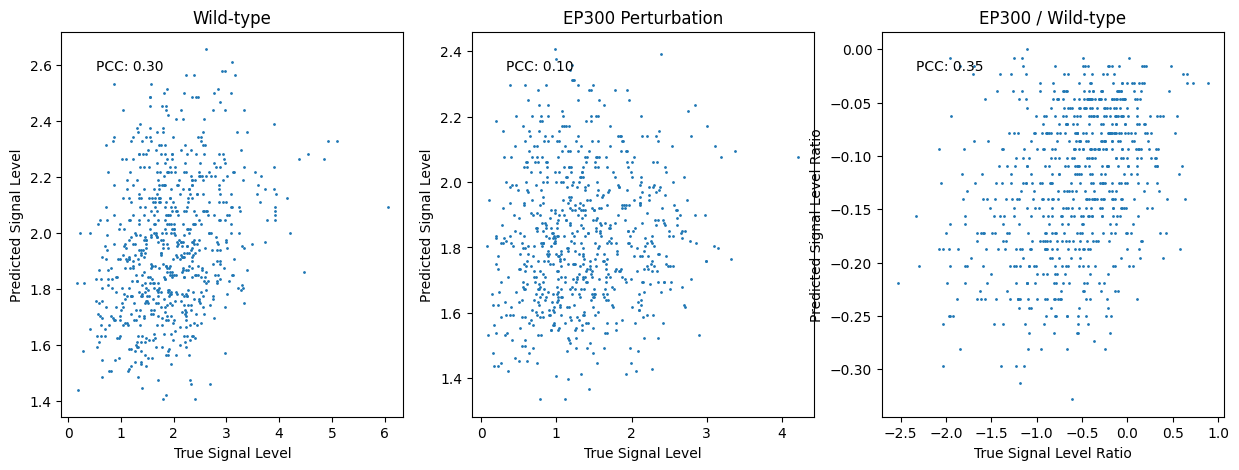

In [22]:
# We show the performance here. 
# Note: the performance is not good enough because the model is not well-trained.
fig, axs = plt.subplots(1,3,figsize=(15,5))
signal_wt = df_supervised["wt"].values
signal_ep300 = df_supervised["ep300"].values

ax = axs[0]
ax.scatter(signal_wt, logits_wt, s=1)
ax.set_xlabel("True Signal Level")
ax.set_ylabel("Predicted Signal Level")
ax.set_title("Wild-type")
pcc = scipy.stats.pearsonr(signal_wt, logits_wt)[0]
ax.text(0.1, 0.9, f"PCC: {pcc:.2f}", transform=ax.transAxes)

ax = axs[1]
ax.scatter(signal_ep300, logits_ep300, s=1)
ax.set_xlabel("True Signal Level")
ax.set_ylabel("Predicted Signal Level")
ax.set_title("EP300 Perturbation")
pcc = scipy.stats.pearsonr(signal_ep300, logits_ep300)[0]
ax.text(0.1, 0.9, f"PCC: {pcc:.2f}", transform=ax.transAxes)


ax = axs[2]
logit_diff = logits_ep300 - logits_wt
signal_diff = signal_ep300 - signal_wt
ax.scatter(signal_diff, logit_diff, s=1)
ax.set_xlabel("True Signal Level Ratio")
ax.set_ylabel("Predicted Signal Level Ratio")
ax.set_title("EP300 / Wild-type")
pcc = scipy.stats.pearsonr(signal_diff, logit_diff)[0]
ax.text(0.1, 0.9, f"PCC: {pcc:.2f}", transform=ax.transAxes)

plt.show()

## Forward: get embeddings
We use the regulator embedding from wild type and perturbed states to calculate distance of regulator embeddings.  
Intuitively, the distance of regulator embeddings on enhancers sensitive to EP300/CREBBP perturbation is larger than the non-sensitive ones, and regulators associated with EP300/CREBBP should have larger distance on sensitive enhancers. 


In [23]:
from chrombert.scripts.utils import HDF5Manager # We provide a convenient class for storing embeddings

if not os.path.exists("tmp_starr"):
    os.makedirs("tmp_starr")

model_emb = model.get_embedding_manager()

dict_shapes = {
    "region":((len(ds_wt), 4), int), 
    "wt":((len(ds_wt),len(model_emb.list_regulator), 768), np.float16), 
    "ep300":((len(ds_wt),len(model_emb.list_regulator), 768), np.float16)
    } # initialize the shapes of the data to be stored in the HDF5 file
with HDF5Manager(os.path.join("tmp_starr","starr_emb.h5"), **dict_shapes) as h5:
    for (batch_wt, batch_ep300) in tqdm(zip(dc_wt.init_dataloader(), dc_ep300.init_dataloader())):
        region = np.concatenate([
            batch_wt["region"].long().cpu().numpy(), 
            batch_wt["build_region_index"].long().cpu().unsqueeze(-1).numpy()
            ], axis = 1
        )
        for k,v in batch_wt.items():
            if isinstance(v, torch.Tensor):
                batch_wt[k] = v.cuda()
                batch_ep300[k] = batch_ep300[k].cuda()
        
        with torch.no_grad():
            emb_wt = model_emb(batch_wt).float().cpu().numpy() # get the embeddings of wild-type
            emb_ep300 = model_emb(batch_ep300).float().cpu().numpy() # get the embeddings of EP300 perturbation
        h5.insert(
            **{"region":region, "wt":emb_wt, "ep300":emb_ep300}
            )
    

Ignoring 3057 cistromes and 82 regulators
Your supervised_file does not contain the 'label' column. Please verify whether ground truth column ('label') is required. If it is not needed, you may disregard this message.
Your supervised_file does not contain the 'label' column. Please verify whether ground truth column ('label') is required. If it is not needed, you may disregard this message.
use perturbation_object in dataset config which high priority than supervised_file


181it [02:11,  1.37it/s]


In [24]:
list_factors = model_emb.list_regulator
list_factors[:10],len(list_factors)

(['adnp',
  'aebp2',
  'aff1',
  'aff4',
  'ago1',
  'ago2',
  'ahr',
  'ahrr',
  'alkbh3',
  'anp32e'],
 991)

In [25]:
# Distance of embeddings on sensitive enhancers
with h5py.File(os.path.join("tmp_starr","starr_emb.h5"), "r") as f:
    emb_decrease_wt = f["wt"][df_supervised["kind"] == "decrease",...].mean(axis = 0)
    emb_decrease_ep300 = f["ep300"][df_supervised["kind"] == "decrease",...].mean(axis = 0)
sims = np.diagonal(cosine_similarity(emb_decrease_wt, emb_decrease_ep300))
df_sim_decreased = pd.DataFrame({"factor": list_factors, "sim": sims,"source": "decreased"})
df_sim_decreased

,factor,sim,source
0,adnp,0.999221,decreased
1,aebp2,0.999145,decreased
2,aff1,0.999035,decreased
3,aff4,0.998830,decreased
4,ago1,0.999297,decreased
...,...,...,...
986,zscan5a,0.999392,decreased
987,zta,0.999194,decreased
988,zxdb,0.999416,decreased
989,zxdc,0.999589,decreased


In [26]:
# Distance of embeddings on non-sensitive enhancers
with h5py.File(os.path.join("tmp_starr","starr_emb.h5"), "r") as f:
    emb_nochange_wt = f["wt"][df_supervised["kind"] == "nochange",...].mean(axis = 0)
    emb_nochange_ep300 = f["ep300"][df_supervised["kind"] == "nochange",...].mean(axis = 0)
sims = np.diagonal(cosine_similarity(emb_nochange_wt, emb_nochange_ep300))
df_sim_nochange = pd.DataFrame({"factor": list_factors, "sim": sims,"source": "nochange"})
df_sim_nochange

,factor,sim,source
0,adnp,0.999463,nochange
1,aebp2,0.999323,nochange
2,aff1,0.999344,nochange
3,aff4,0.999247,nochange
4,ago1,0.999504,nochange
...,...,...,...
986,zscan5a,0.999555,nochange
987,zta,0.999570,nochange
988,zxdb,0.999606,nochange
989,zxdc,0.999685,nochange


In [27]:
# Stack the results
df_sim = pd.concat([df_sim_decreased, df_sim_nochange]).set_index(["factor","source"])["sim"].unstack()
df_shift = 1 - df_sim
df_shift

source,decreased,nochange
factor,,
adnp,0.000779,0.000537
aebp2,0.000855,0.000677
aff1,0.000965,0.000656
aff4,0.001170,0.000753
ago1,0.000703,0.000496
...,...,...
zscan5a,0.000608,0.000445
zta,0.000806,0.000430
zxdb,0.000584,0.000394


We observe larger embedding shift of EP300/CREBBP sensitive enhancers here

/tmp/ipykernel_1705212/443859759.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([df_shift["decreased"], df_shift["nochange"]], labels = ["Decreased", "No Change"], showfliers=False)


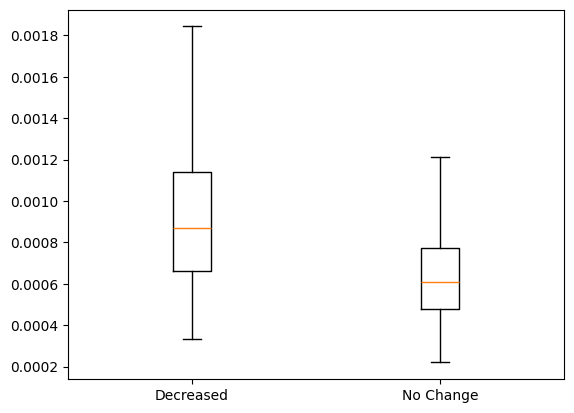

TtestResult(statistic=0.9246101672047551, pvalue=0.3552813911246604, df=1980.0)

In [28]:
# Boxplot of embedding shifts, showing larger shift on sensitive enhancers
plt.boxplot([df_shift["decreased"], df_shift["nochange"]], labels = ["Decreased", "No Change"], showfliers=False)
plt.show()
scipy.stats.ttest_ind(df_shift["decreased"], df_shift["nochange"])

We can also observe larger embedding shift of EP300/CREBBP associated regulators on sensitive enhancers. 

In [29]:
# we select top 50 factors with the highest cosine similarity with EP300 
with h5py.File(os.path.join("tmp_starr","starr_emb.h5"), "r") as f:
    emb_all_wt = f["wt"][:,...].mean(axis = 0)
    ser_sim_with_ep300 = pd.DataFrame(data = cosine_similarity(emb_all_wt), columns= list_factors, index = list_factors)["ep300"]
ser_sim_with_ep300 = ser_sim_with_ep300.loc[~ser_sim_with_ep300.index.isin(["ep300","crebbp"])].sort_values(ascending = False).head(50)
ser_sim_with_ep300

med1       0.912179
brd4       0.898527
smarca4    0.887474
myc        0.884520
foxm1      0.877207
tcf12      0.869119
rxra       0.864270
stat3      0.860204
nr3c1      0.856566
rela       0.854440
nipbl      0.851435
cdk9       0.844094
ets1       0.843467
tcf7l2     0.843425
sox2       0.835494
runx1      0.834055
e2f1       0.831583
cdk8       0.830999
stat1      0.830734
tal1       0.822797
sin3a      0.819663
hdac2      0.819198
smarcc1    0.816048
rbpj       0.815343
smad1      0.814176
tead4      0.811195
e2f4       0.810752
junb       0.810572
gabpa      0.809529
bcl11a     0.808997
chd1       0.808096
tp53       0.807762
sp1        0.807046
gata2      0.804436
hdac1      0.802669
smad3      0.802053
taf1       0.800188
hsf1       0.795786
gata3      0.795238
lyl1       0.794817
kdm1a      0.792298
zbtb17     0.788927
ezh2       0.788191
rnf2       0.788014
rest       0.787572
brca1      0.787291
smad4      0.785382
ubtf       0.781261
lef1       0.781023
zbtb33     0.778925


/tmp/ipykernel_1705212/139458382.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([v1, v2], labels = ["Related", "Others"], showfliers=False)


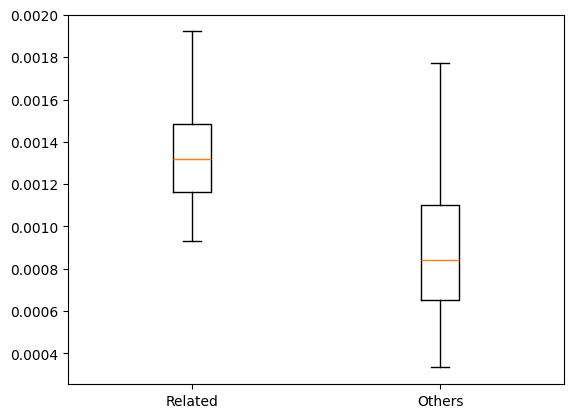

MannwhitneyuResult(statistic=39529.0, pvalue=4.8717532533893065e-16)

In [30]:
# Boxplot of embedding shifts, showing larger shift for EP300/CREBBP associated regulators
v1 = df_shift.loc[ser_sim_with_ep300.index,"decreased"]
v2 = df_shift.loc[~df_shift.index.isin(ser_sim_with_ep300.index),"decreased"]
plt.boxplot([v1, v2], labels = ["Related", "Others"], showfliers=False)
plt.show()
scipy.stats.mannwhitneyu(v1, v2)